# Domain 1 Survey Bot - Quick Test

This notebook demonstrates the Pydantic AI survey bot for Domain 1: Demographics & Vulnerability Factors

## Setup

First, let's import the necessary modules and load environment variables:

In [1]:
import asyncio
from dotenv import load_dotenv
from models.domain1 import Domain1Data, ChildInfo, CaregiverType, ChildAgeRange
from agents.domain1_agent import get_conversation_agent, get_extraction_agent, Domain1SurveyDeps

# Load environment variables FIRST
load_dotenv()

print("✅ Imports successful!")

✅ Imports successful!


## Test 1: Create Sample Data Manually

Let's create a sample household profile to see how the risk scoring works:

In [2]:
# Create sample children
child1 = ChildInfo(
    age_months=8,  # High-risk age (6-11 months)
    has_malnutrition_signs=True
)

child2 = ChildInfo(
    age_months=18,  # Peak vulnerability (12-23 months)
    has_malnutrition_signs=False
)

# Create household profile
sample_data = Domain1Data(
    num_children_under_5=2,
    children=[child1, child2],
    has_elderly_members=True,
    has_immunocompromised_members=False,
    primary_caregiver=CaregiverType.SINGLE_MOTHER
)

print("Sample Household Created!")
print(f"\nChild 1: {child1.age_months} months, Age Range: {child1.age_range.value}")
print(f"Vulnerability Score: {child1.vulnerability_score}")
print(f"\nChild 2: {child2.age_months} months, Age Range: {child2.age_range.value}")
print(f"Vulnerability Score: {child2.vulnerability_score}")

Sample Household Created!

Child 1: 8 months, Age Range: 6-11 months
Vulnerability Score: 2.58

Child 2: 18 months, Age Range: 12-23 months
Vulnerability Score: 2.31


## Test 2: View Risk Summary

In [3]:
# Get risk summary
summary = sample_data.get_risk_summary()

print("="*60)
print("RISK SUMMARY")
print("="*60)
for key, value in summary.items():
    print(f"{key:.<40} {value}")
print("="*60)

RISK SUMMARY
domain.................................. Demographics & Vulnerability Factors
domain_weight........................... 0.1
total_children.......................... 2
high_risk_age_children.................. 2
malnourished_children................... 1
single_parent_household................. True
vulnerable_members_present.............. True
overall_vulnerability_score............. 3.09
weighted_score.......................... 0.31


## Test 3: Interactive AI Survey (Simulated)

Let's test the AI agent with a pre-defined conversation:

In [4]:
# Create dependencies
deps = Domain1SurveyDeps()

# Test a simple interaction
async def test_agent_greeting():
    agent = get_conversation_agent()
    result = await agent.run(
        "Start the survey",
        deps=deps
    )
    print("Agent Response:")
    print(result.output)
    return result

# Run the async function
result = await test_agent_greeting()

Agent Response:
Hello, I have a few quick questions for a survey. How many children under five years old live in your household?


## Test 4: Complete Survey Simulation

Simulate a complete survey with predefined responses:

In [5]:
print("Starting survey simulation...")

async def simulate_complete_survey():
    """Simulate a complete survey with programmatic responses (patched)"""
    print("Creating agents...")
    conversation_agent = get_conversation_agent()
    deps = Domain1SurveyDeps()

    print("  Priming agent with greeting + Q1...")
    prime = await conversation_agent.run(
        "Start the survey by greeting the respondent and then ask Q1.",
        deps=deps
    )
    prime_text = str(prime.output)
    deps.conversation_history.append(f"Agent: {prime_text}")
    print(f"Agent: {prime_text[:200]}...")

    conversation = [
        # Q1
        ("There are two children under five in my household.", "num_children"),
        # Q2
        ("The first child is 8 months old.", "child1_age"),
        # Q3
        ("Yes, the first child has shown some weight loss recently.", "child1_malnutrition"),
        # Q4
        ("The second child is 18 months old.", "child2_age"),
        # Q5
        ("No, the second child has not shown signs of malnutrition.", "child2_malnutrition"),
        # Q6
        ("Yes, my mother lives with us and she is 75; no one is immunocompromised; the mother mainly takes care of the small children during the day.", "elderly_immuno_caregiver"),
    ]

    print("Starting conversation loop...")
    print("="*60)

    for i, (user_input, stage) in enumerate(conversation):
        print(f"\n[{i+1}/{len(conversation)}] [{stage.upper()}]")
        print(f"Respondent: {user_input}")  # 统一标签为 Respondent
        deps.conversation_history.append(f"Respondent: {user_input}")

        try:
            transcript = "\n".join(deps.conversation_history)
            next_step_prompt = f"""You are continuing a fixed 6-question survey.

Transcript so far:
{transcript}

The respondent just answered: "{user_input}"

Rules:
- Ask only the NEXT required question from the 6-question script.
- Do not repeat earlier questions already asked AND answered.
- If all six questions are answered, reply exactly with: SURVEY_COMPLETE."""
            print("  Calling conversation agent...")
            result = await conversation_agent.run(next_step_prompt, deps=deps)
            print(f"  Got result, type: {type(result.output)}")

            agent_response = str(result.output)
            deps.conversation_history.append(f"Agent: {agent_response}")
            print(f"Agent: {agent_response[:200]}...") 

            if "SURVEY_COMPLETE" in agent_response:
                print("\n" + "="*60)
                print("SURVEY COMPLETE - Extracting structured data...")
                print("="*60)

                extraction_agent = get_extraction_agent()
                conversation_text = "\n".join(deps.conversation_history)
                extraction_result = await extraction_agent.run(
                    f"Extract the household data from this conversation:\n\n{conversation_text}"
                )

                print("Extraction successful!")
                print(f"Type: {type(extraction_result.output)}")
                print(f"Data: {extraction_result.output}")
                return extraction_result.output

        except Exception as e:
            print(f"ERROR in loop: {e}")
            import traceback
            traceback.print_exc()
            continue

    print("\n" + "="*60)
    print("Survey ended - forcing extraction...")
    print("="*60)
    extraction_agent = get_extraction_agent()
    conversation_text = "\n".join(deps.conversation_history)
    print(f"Conversation has {len(deps.conversation_history)} messages")

    extraction_result = await extraction_agent.run(
        f"Extract the household data from this conversation:\n\n{conversation_text}"
    )
    print("Extraction complete!")
    print(f"Type: {type(extraction_result.output)}")
    print(f"Data: {extraction_result.output}")
    return extraction_result.output

# Run simulation
print("About to run simulate_complete_survey()...")
survey_result = await simulate_complete_survey()
print(f"\nFinal result type: {type(survey_result)}")
print(f"Final result: {survey_result}")

Starting survey simulation...
About to run simulate_complete_survey()...
Creating agents...
  Priming agent with greeting + Q1...
Agent: Hello, thank you for participating in this survey. How many children under five years old live in your household?...
Starting conversation loop...

[1/6] [NUM_CHILDREN]
Respondent: There are two children under five in my household.
  Calling conversation agent...
  Got result, type: <class 'str'>
Agent: "Please tell me the age in months of the first child under five."...

[2/6] [CHILD1_AGE]
Respondent: The first child is 8 months old.
  Calling conversation agent...
  Got result, type: <class 'str'>
Agent: "Has the first child shown signs of malnutrition, like weight loss or not growing well?"...

[3/6] [CHILD1_MALNUTRITION]
Respondent: Yes, the first child has shown some weight loss recently.
  Calling conversation agent...
  Got result, type: <class 'str'>
Agent: "Please tell me the age in months of the second child under five. If there is no second

## Test 5: Display Final Results

In [6]:
try:
    from models.domain1 import Domain1Data
except ModuleNotFoundError:
    from domain1 import Domain1Data

if survey_result:
    if isinstance(survey_result, dict):
        d1 = Domain1Data.from_answers(survey_result, strict_len=False)
    else:
        d1 = survey_result

    print("\n" + "="*60)
    print("FINAL SURVEY RESULTS")
    print("="*60)

    # Show structured data
    print("\n📋 Structured Data:")
    print(d1.model_dump_json(indent=2))

    # Show risk summary
    print("\n📊 Risk Summary:")
    summary = d1.get_risk_summary()
    for key, value in summary.items():
        print(f"  {key}: {value}")

    # Show individual child scores
    print("\n👶 Individual Child Vulnerability:")
    for i, child in enumerate(d1.children, 1):
        print(f"\n  Child {i}:")
        print(f"    Age: {child.age_months} months ({child.age_range.value})")
        print(f"    Malnutrition: {'Yes' if child.has_malnutrition_signs else 'No'}")
        print(f"    Vulnerability Score: {child.vulnerability_score}")
else:
    print("❌ Survey did not complete successfully")


FINAL SURVEY RESULTS

📋 Structured Data:
{
  "num_children_under_5": 2,
  "children": [
    {
      "age_months": 8,
      "has_malnutrition_signs": true
    },
    {
      "age_months": 18,
      "has_malnutrition_signs": false
    }
  ],
  "has_elderly_members": true,
  "has_immunocompromised_members": false,
  "primary_caregiver": "Both parents"
}

📊 Risk Summary:
  domain: Demographics & Vulnerability Factors
  domain_weight: 0.1
  total_children: 2
  high_risk_age_children: 2
  malnourished_children: 1
  single_parent_household: False
  vulnerable_members_present: True
  overall_vulnerability_score: 2.69
  weighted_score: 0.27

👶 Individual Child Vulnerability:

  Child 1:
    Age: 8 months (6-11 months)
    Malnutrition: Yes
    Vulnerability Score: 2.58

  Child 2:
    Age: 18 months (12-23 months)
    Malnutrition: No
    Vulnerability Score: 2.31


## Test 6: Compare Different Scenarios

Let's compare vulnerability scores across different household scenarios:

In [7]:
# Scenario 1: Low Risk Household
low_risk = Domain1Data(
    num_children_under_5=1,
    children=[ChildInfo(age_months=36, has_malnutrition_signs=False)],
    has_elderly_members=False,
    has_immunocompromised_members=False,
    primary_caregiver=CaregiverType.BOTH_PARENTS
)

# Scenario 2: High Risk Household
high_risk = Domain1Data(
    num_children_under_5=3,
    children=[
        ChildInfo(age_months=8, has_malnutrition_signs=True),
        ChildInfo(age_months=14, has_malnutrition_signs=True),
        ChildInfo(age_months=30, has_malnutrition_signs=False),
    ],
    has_elderly_members=True,
    has_immunocompromised_members=True,
    primary_caregiver=CaregiverType.SINGLE_MOTHER
)

# Scenario 3: Medium Risk Household
medium_risk = Domain1Data(
    num_children_under_5=2,
    children=[
        ChildInfo(age_months=15, has_malnutrition_signs=False),
        ChildInfo(age_months=40, has_malnutrition_signs=False),
    ],
    has_elderly_members=True,
    has_immunocompromised_members=False,
    primary_caregiver=CaregiverType.BOTH_PARENTS
)

# Compare scores
import pandas as pd

scenarios = {
    'Low Risk': low_risk,
    'Medium Risk': medium_risk,
    'High Risk': high_risk
}

comparison_data = []
for name, scenario in scenarios.items():
    summary = scenario.get_risk_summary()
    comparison_data.append({
        'Scenario': name,
        'Total Children': summary['total_children'],
        'High-Risk Age': summary['high_risk_age_children'],
        'Malnourished': summary['malnourished_children'],
        'Single Parent': 'Yes' if summary['single_parent_household'] else 'No',
        'Vulnerable Members': 'Yes' if summary['vulnerable_members_present'] else 'No',
        'Vulnerability Score': summary['overall_vulnerability_score'],
        'Weighted Score': summary['weighted_score']
    })

df = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("SCENARIO COMPARISON")
print("="*80)
print(df.to_string(index=False))
print("="*80)


SCENARIO COMPARISON
   Scenario  Total Children  High-Risk Age  Malnourished Single Parent Vulnerable Members  Vulnerability Score  Weighted Score
   Low Risk               1              0             0            No                 No                 1.50            0.15
Medium Risk               2              1             0            No                Yes                 2.10            0.21
  High Risk               3              2             2           Yes                Yes                 3.11            0.31


## Test 7: Visualize Risk Factors

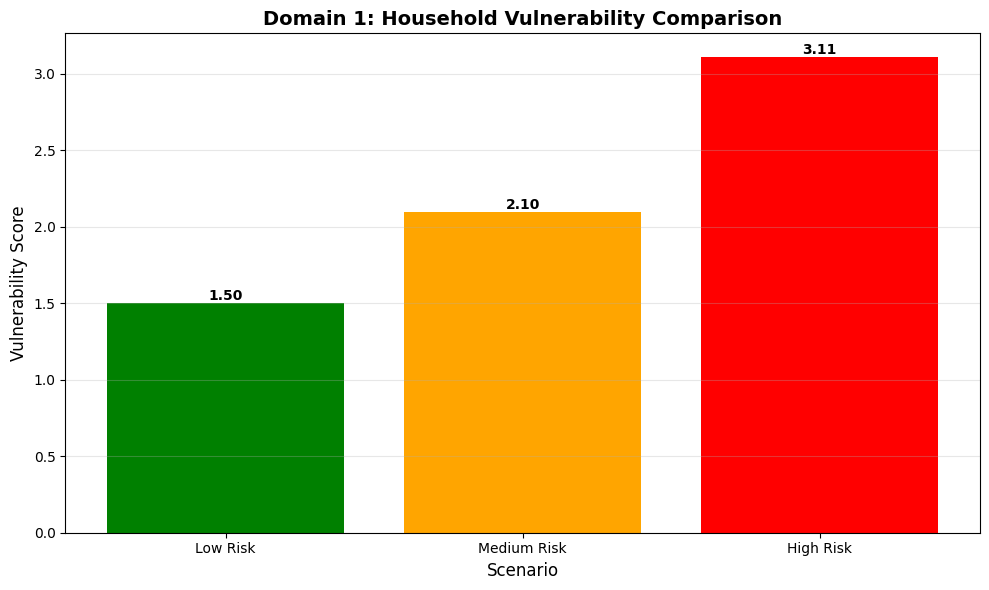

In [8]:
import matplotlib.pyplot as plt

# Extract scores
scenario_names = [item['Scenario'] for item in comparison_data]
vulnerability_scores = [item['Vulnerability Score'] for item in comparison_data]

# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(scenario_names, vulnerability_scores, color=['green', 'orange', 'red'])
plt.xlabel('Scenario', fontsize=12)
plt.ylabel('Vulnerability Score', fontsize=12)
plt.title('Domain 1: Household Vulnerability Comparison', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Summary

This notebook demonstrates:
1. ✅ Manual data creation with Pydantic models
2. ✅ Risk scoring based on evidence-based factors
3. ✅ AI agent interaction
4. ✅ Complete survey simulation
5. ✅ Scenario comparison
6. ✅ Data visualization

The system correctly:
- Identifies high-risk age windows (6-23 months)
- Adjusts scores for malnutrition (aOR 1.14)
- Accounts for household composition factors
- Provides weighted scores for multi-domain assessment